In [1]:
#!pip install factor_analyzer

In [2]:
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

import plotly.express as pe
import plotly.offline as po

import os
import glob
import re


from prettytable import PrettyTable

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, r2_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_regression
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import randint as sp_randint, pearsonr
from ctypes import LibraryLoader
from imblearn.over_sampling import SMOTE
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

In [3]:
url = "https://raw.githubusercontent.com/ooseni/Hamoye-Datasets/main/insurance.csv"

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
data = pd.read_csv(url, sep=',')

In [6]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Exploratory Data Analysis

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
#Get the datatypes of each column in the dataset
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [9]:
#Get the descriptive summary of the dataset
data.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [10]:
#preferred arrangement
arrangement = ['region', 'charges', 'age', 'sex', 'children', 'bmi', 'smoker']

In [11]:
q1_data = data[[x for x in arrangement]]

In [12]:
q1_data.head(2)

,region,charges,age,sex,children,bmi,smoker
0,southwest,16884.9240,19,female,0,27.90,yes
1,southeast,1725.5523,18,male,1,33.77,no


In [13]:
table = PrettyTable(["Columns with missing data", "Sum of missing values"])
for x in q1_data.columns:
    if q1_data[x].isna().sum() >= 1:
        table.add_row([x, q1_data[x].isna().sum()])
print(table)

+---------------------------+-----------------------+
| Columns with missing data | Sum of missing values |
+---------------------------+-----------------------+
+---------------------------+-----------------------+


**Hence we have no missing values in the datasets**

### Data Visualization

In [14]:
df = data.copy()

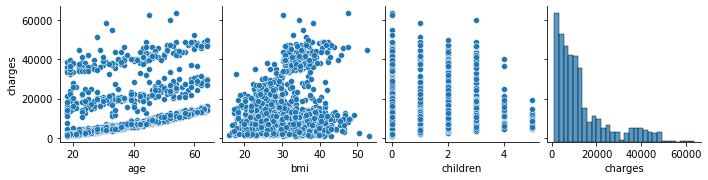

In [15]:
data_num = df.select_dtypes(include = ['float64','int64']);
sns.pairplot(data=data_num,x_vars=data_num.columns,y_vars=['charges']);

In [16]:
data_num['sex']= df['sex'];

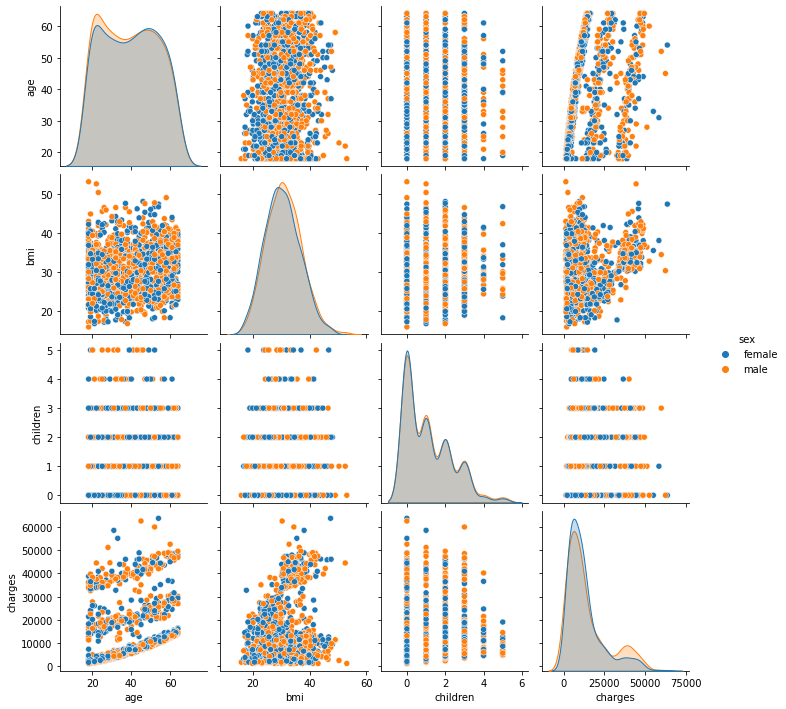

In [17]:
sns.pairplot(data = data_num,hue='sex');

No obvious relation/distinction between male and female.

In [18]:
data_num.drop(['sex'],axis=1,inplace=True)
data_num.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


Text(0.5, 1.0, 'Distribution of Charges')

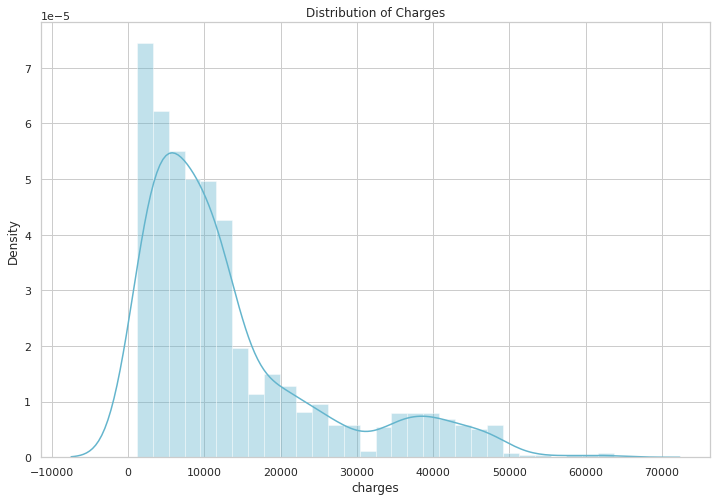

In [19]:
sns.set(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.distplot(df['charges'], kde = True, color = 'c')
plt.title('Distribution of Charges')

This distribution is right-skewed. To make it closer to normal we can apply natural log

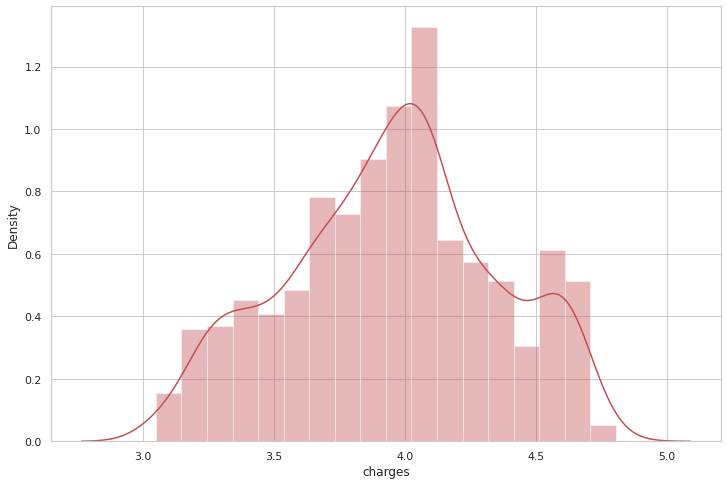

In [20]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.distplot(np.log10(df['charges']), kde = True, color = 'r' )

**Now let's look at the charges by region**

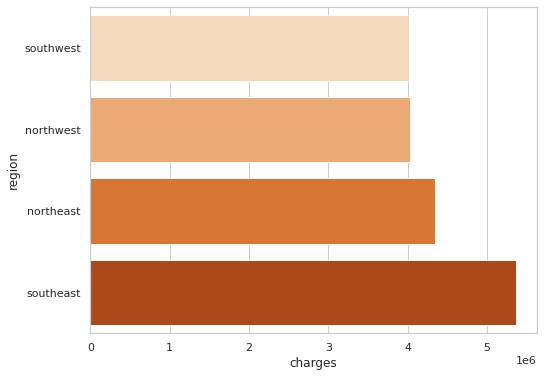

In [21]:
charges = df['charges'].groupby(df.region).sum().sort_values(ascending = True)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.barplot(charges.head(), charges.head().index, palette='Oranges')

So overall the highest medical charges are in the Southeast and the lowest are in the Southwest. Taking into consideration certain factors (sex, smoking, having children), let's see how it changes by region.

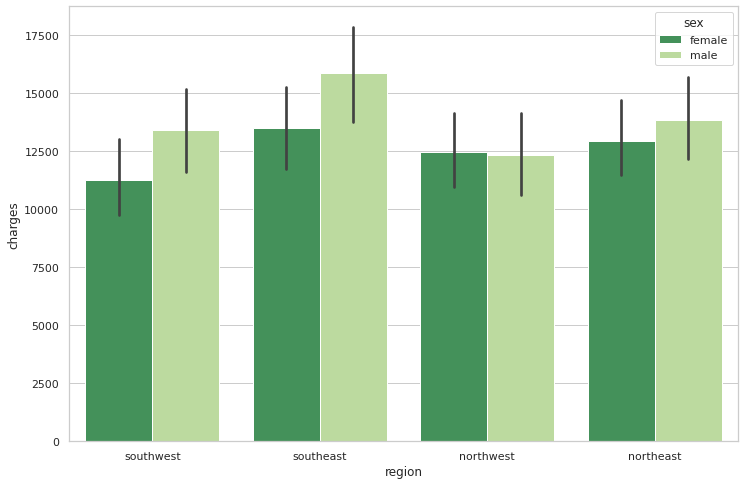

In [22]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='sex', data=df, palette='YlGn_r')

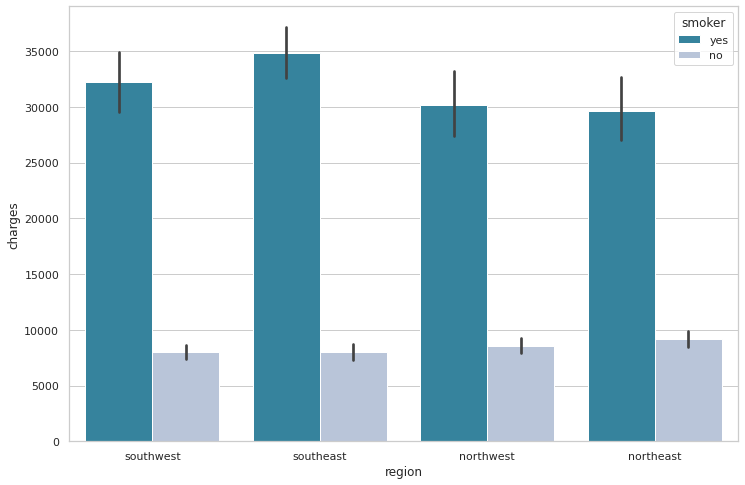

In [23]:
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.barplot(x = 'region', y = 'charges',
                 hue='smoker', data=df, palette='PuBuGn_r')

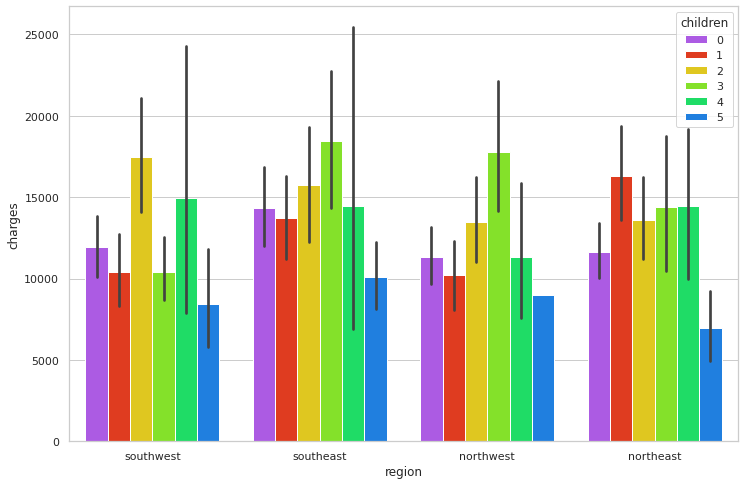

In [24]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='children', data=df, palette='gist_ncar_r')

As we can see from these bar plots, the highest charges due to smoking are still in the Southeast, but the lowest is in the Northeast. People in the Southwest generally smoke more than people in the Northeast, but people in the Northeast have higher charges by gender than in the Southwest and Northwest overall. And people with children tend to have higher medical costs overall as well.

**Unique Values**

In [25]:
{col:list(df[col].unique()) for col in df.select_dtypes("object")}

{'sex': ['female', 'male'],
 'smoker': ['yes', 'no'],
 'region': ['southwest', 'southeast', 'northwest', 'northeast']}

In [26]:
def pie(feature,title,explode,colors):
    
    serie = feature.value_counts()


    serie.plot(kind='pie',title=title, figsize=[20,8],
                     colors=colors,explode=explode,
          autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*serie.sum()))

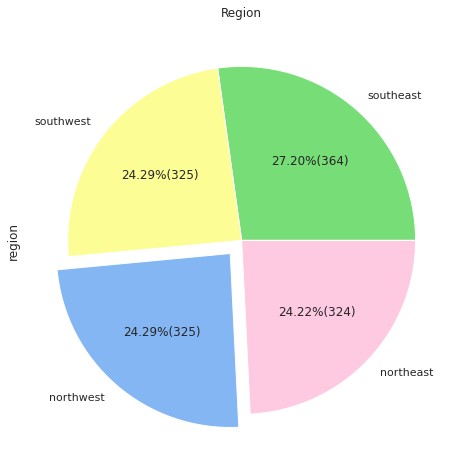

In [27]:
colors=['#77dd77','#fdfd96','#84b6f4','#fdcae1']
explode= [0,0,0.1,0]
_ = pie(df.region,'Region',explode,colors)

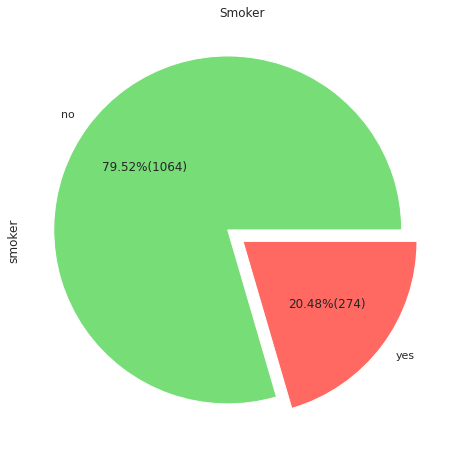

In [28]:
colors=['#77dd77','#ff6961']
explode=[0.1,0.01]

_ = pie(df.smoker,'Smoker',explode,colors)

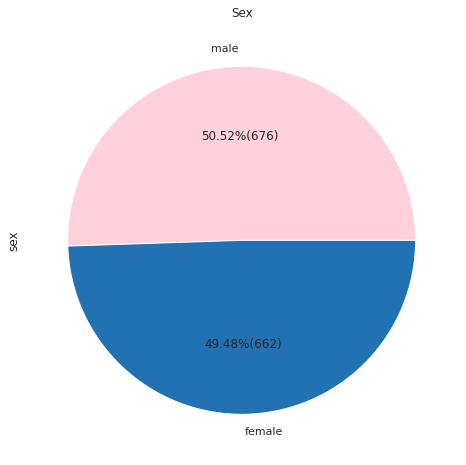

In [29]:
explode=[0,0]
colors=['#FFD1DC','#2271b3']

_ = pie(df.sex,'Sex',explode,colors)

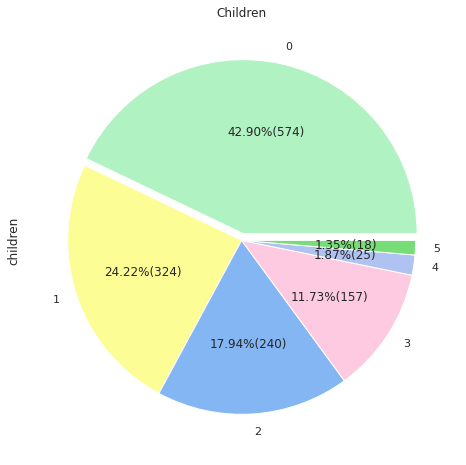

In [30]:
explode=[0.04,0,0,0,0,0]
colors=['#b0f2c2','#fdfd96','#84b6f4','#fdcae1','#b0c2f2','#77dd77']

_ = pie(df.children,'Children',explode,colors)

In [31]:
sns.set_style(style="whitegrid")

In [32]:
def histogram(feature,title):


  fig,ax=plt.subplots(1,1,figsize=(20,8))

  ax.set_title(title)
  ax.hist(df[feature],ec="k",color="#FADA5E",lw=3)


  ax.axvline(df[feature].mean(),
           color="red",
           linestyle="--",
           lw=3,label="Mean")


  ax.axvline(df[feature].median(),
           color="blue",
           linestyle="--",
           lw=3,label="Median")

  ax.legend()

  plt.show()

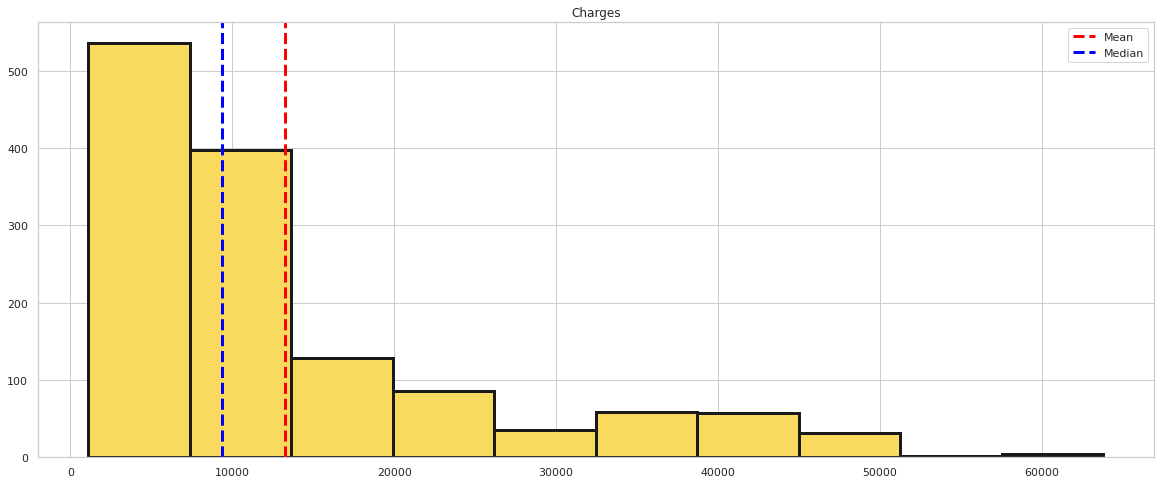

In [33]:
_ = histogram("charges","Charges")

**Now let's analyze the medical charges by age, bmi and children according to the smoking factor**

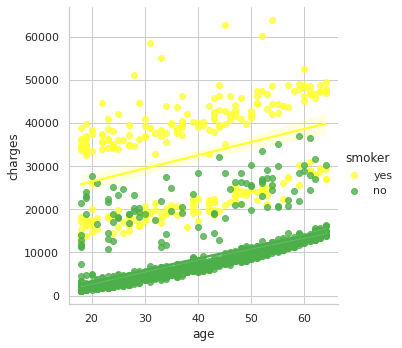

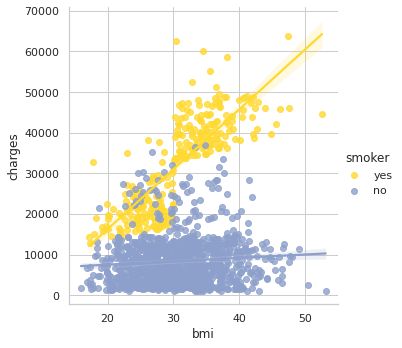

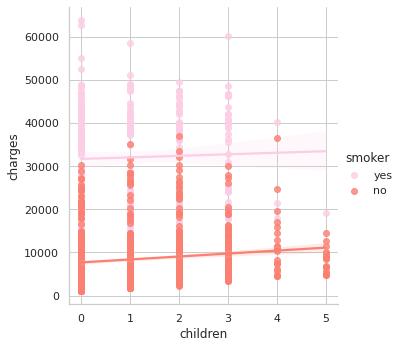

In [34]:
ax = sns.lmplot(x = 'age', y = 'charges', data=df, hue='smoker', palette='Set1_r')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=df, hue='smoker', palette='Set2_r')
ax = sns.lmplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='Set3_r')

Smoking has the highest impact on medical costs, even though the costs are growing with age, BMI and children. Also, people who have children generally smoke less, which the following violin plots shows too

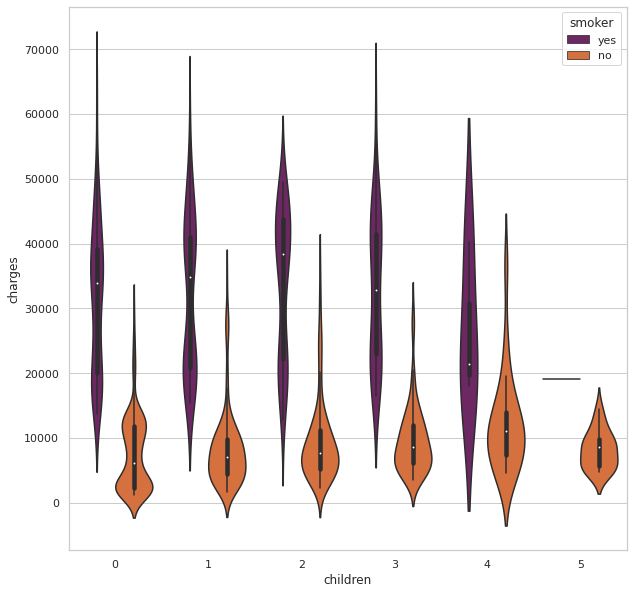

In [35]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.violinplot(x = 'children', y = 'charges', data=df,
                 orient='v', hue='smoker', palette='inferno')

In [36]:
# Checking for correlation

corr = df.corr()
corr['charges'].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

#### Grouping the data by columns

In [37]:
df_sex = df.groupby(['sex', 'children'])
df_sex.first()

age     bmi smoker     region      charges
sex    children                                            
female 0          19  27.900    yes  southwest  16884.92400
       1          46  33.440     no  southeast   8240.58960
       2          55  32.775     no  northwest  12268.63225
       3          37  27.740     no  northwest   7281.50560
       4          48  41.230     no  northwest  11033.66170
       5          19  28.600     no  southwest   4687.79700
male   0          33  22.705     no  northwest  21984.47061
       1          18  33.770     no  southeast   1725.55230
       2          37  29.830     no  northeast   6406.41070
       3          28  33.000     no  southeast   4449.46200
       4          25  33.660     no  southeast   4504.66240
       5          31  28.500     no  northeast   6799.45800

In [38]:
df_reg = df.groupby(['region', 'children'])
df_reg.first()

age     sex     bmi smoker      charges
region    children                                         
northeast 0          25    male  26.220     no   2721.32080
          1          52  female  30.780     no  10797.33620
          2          37    male  29.830     no   6406.41070
          3          43    male  27.360     no   8606.21740
          4          47    male  28.215     no  10407.08585
          5          31    male  28.500     no   6799.45800
northwest 0          33    male  22.705     no  21984.47061
          1          23    male  17.385     no   2775.19215
          2          37    male  28.025     no   6203.90175
          3          37  female  27.740     no   7281.50560
          4          48  female  41.230     no  11033.66170
          5          39  female  24.225     no   8965.79575
southeast 0          31  female  25.740     no   3756.62160
          1          18    male  33.770     no   1725.55230
          2          31  female  36.630     no   4949.75870
          3          28    male  33.000     no   4449.46200
          4          25    male  33.660     no   4504.66240
          5          45    male  24.310     no   9788.86590
southwest 0          19  female  27.900    yes  16884.92400
          1          19    male  24.600     no   1837.23700
          2          31    male  36.300    yes  38711.00000
          3          53  female  28.100     no  11741.72600
          4          39    male  29.600     no   7512.26700
          5          19  female  28.600     no   4687.79700

In [39]:
df_smo = df.groupby(['smoker', 'age'])
df_smo.first()

sex     bmi  children     region      charges
smoker age                                                  
no     18     male  33.770         1  southeast   1725.55230
       19     male  24.600         1  southwest   1837.23700
       20   female  28.975         0  northwest   2257.47525
       21   female  33.630         2  northwest   3579.82870
       22   female  39.805         0  northeast   2755.02095
       23     male  34.400         0  southwest   1826.84300
       24   female  26.600         0  northeast   3046.06200
       25     male  26.220         0  northeast   2721.32080
       26     male  20.800         0  southwest   2302.30000
       27     male  18.905         3  northeast   4827.90495
       28     male  33.000         3  southeast   4449.46200
       29   female  29.590         1  southeast   3947.41310
       30   female  32.400         1  southwest   4149.73600
       31   female  25.740         0  southeast   3756.62160
       32     male  28.880         0  northwest   3866.85520
       33     male  22.705         0  northwest  21984.47061
       34   female  37.335         2  northwest   5989.52365
       35     male  34.770         2  northwest   5729.00530
       36   female  26.200         0  southwest   4883.86600
       37   female  27.740         3  northwest   7281.50560
       38     male  37.050         1  northeast   6079.67150
       39   female  32.800         0  southwest   5649.71500
       40   female  28.690         3  northwest   8059.67910
       41     male  21.780         1  southeast   6272.47720
       42   female  36.195         1  northwest   7443.64305
       43     male  27.360         3  northeast   8606.21740
       44     male  27.400         2  southwest   7726.85400
       45   female  38.285         0  northeast   7935.29115
       46   female  33.440         1  southeast   8240.58960
       47   female  33.915         3  northwest  10115.00885
       48   female  41.230         4  northwest  11033.66170
       49   female  27.170         0  southeast   8601.32930
       50   female  27.830         3  southeast  19749.38338
       51   female  37.730         1  southeast   9877.60770
       52   female  30.780         1  northeast  10797.33620
       53   female  28.100         3  southwest  11741.72600
       54   female  30.800         3  southwest  12105.32000
       55   female  32.775         2  northwest  12268.63225
       56   female  39.820         0  southeast  11090.71780
       57     male  34.010         0  northwest  11356.66090
       58   female  31.825         2  northeast  13607.36875
       59   female  27.720         3  southeast  14001.13380
       60   female  25.840         0  northwest  28923.13692
       61   female  39.100         2  southwest  14235.07200
       62   female  32.965         3  northwest  15612.19335
       63   female  23.085         0  northeast  14451.83515
       64     male  24.700         1  northwest  30166.61817
yes    18     male  31.680         2  southeast  34303.16720
       19   female  27.900         0  southwest  16884.92400
       20   female  22.420         0  northwest  14711.74380
       21     male  25.700         4  southwest  17942.10600
       22     male  35.600         0  southwest  35585.57600
       23   female  36.670         2  northeast  38511.62830
       24     male  40.150         0  southeast  38126.24650
       25     male  45.540         2  southeast  42112.23560
       26     male  32.900         2  southwest  36085.21900
       27     male  42.130         0  southeast  39611.75770
       28     male  36.400         1  southwest  51194.55914
       29   female  27.940         1  southeast  19107.77960
       30     male  35.300         0  southwest  36837.46700
       31     male  36.300         2  southwest  38711.00000
       32   female  17.765         2  northwest  32734.18630
       33   female  33.500         0  southwest  37079.37200
       34   female  31.920         1  northeast  3

In [40]:
df_chg = df.groupby(['region', 'charges'])
df_chg.first(30)

age     bmi  children
region    charges                            
northeast 1694.796400    18  15.960         0
          1702.455300    18  21.470         0
          1704.568100    18  22.990         0
          1704.700150    18  23.085         0
          1705.624500    18  23.750         0
          1708.001400    18  25.460         0
          1708.925750    18  26.125         0
          1712.227000    18  28.500         0
          1967.022700    20  27.930         0
          1984.453300    20  40.470         0
          2102.264700    21  26.030         0
          2104.113400    21  27.360         0
          2196.473200    18  25.080         0
          2198.189850    18  26.315         0
          2200.830850    18  28.215         0
          2203.471850    18  30.115         0
          2203.735950    18  30.305         0
          2205.980800    18  31.920         0
          2207.697450    18  33.155         0
          2211.130750    18  35.625         0
          2217.469150    18  40.185         0
          2217.601200    18  40.280         0
          2250.835200    22  28.880         0
          2254.796700    22  31.730         0
          2395.171550    23  23.845         0
          2396.095900    23  24.510         0
          2457.211150    20  28.785         0
          2459.720100    20  30.590         0
          2585.850650    21  22.135         0
          2721.320800    25  26.220         0
          2727.395100    25  30.590         0
          2731.912200    22  23.180         0
          2741.948000    22  30.400         0
          2755.020950    22  39.805         0
          2897.323500    26  29.450         0
          2899.489350    23  34.865         0
          3044.213300    24  25.270         0
          3046.062000    24  26.600         0
          3070.808700    27  26.030         0
          3167.455850    21  16.815         1
          3206.491350    25  23.465         0
          3213.622050    25  28.595         0
          3268.846650    28  35.435         0
          3279.868550    21  25.745         2
          3309.792600    25  25.840         1
          3385.399150    26  28.785         0
          3393.356350    18  38.665         2
          3481.868000    18  30.400         3
          3490.549100    26  32.490         1
          3558.620250    27  25.175         0
          3645.089400    30  25.460         0
          3732.625100    28  17.290         0
          3857.759250    31  30.875         0
          3861.209650    21  20.235         3
          3925.758200    22  34.580         2
          3943.595400    29  31.160         0
          4005.422500    22  19.950         3
          4040.558250    29  28.975         1
          4137.522700    30  27.930         0
          4237.126550    30  27.645         1
          4337.735200    28  28.880         1
          4347.023350    31  31.065         0
          4428.887850    28  22.515         2
          4435.094200    28  26.980         2
          4438.263400    28  29.260         2
          4441.213150    31  26.885         1
          4500.339250    34  21.375         0
          4518.826250    34  34.675         0
          4544.234800    32  20.520         0
          4561.188500    18  31.350         4
          4564.191450    26  29.355         2
          4661.286350    26  27.265         3
          4667.607650    32  37.335         1
          4718.203550    30  21.945         1
          4719.524050    30  22.895         1
          4827.904950    27  18.905         3
          4846.920150    27  32.585         3
          4915.059850    20  30.115         5
          4992.376400    34  23.560         0
          5031.269550    31  27.645         2
          5148.552600    32  31.540         1
          5209.578850    29  22.515         3
          5227.988750    35  26.125         0
          5354.074650    33  22.135         1
          5428.727700    30  37.430         3
          5458.046450 

In [41]:
df_smo = df.groupby(by=['smoker', 'region'],group_keys=True)
df_smo.first()

age     sex     bmi  children      charges
smoker region                                               
no     northeast   37    male  29.830         2   6406.41070
       northwest   33    male  22.705         0  21984.47061
       southeast   18    male  33.770         1   1725.55230
       southwest   23    male  34.400         0   1826.84300
yes    northeast   34  female  31.920         1  37701.87680
       northwest   58    male  36.955         2  47496.49445
       southeast   62  female  26.290         0  27808.72510
       southwest   19  female  27.900         0  16884.92400

In [42]:
df.groupby(by=["charges"]).sum()

,age,bmi,children
charges,,,
1121.873900,18,23.210,0
1131.506600,18,30.140,0
1135.940700,18,33.330,0
1136.399400,18,33.660,0
1137.011000,18,34.100,0
1137.469700,18,34.430,0
1141.445100,18,37.290,0
1146.796600,18,41.140,0
1149.395900,18,43.010,0


In [43]:
df.groupby(['region', 'charges']).sum()

age     bmi  children
region    charges                            
northeast 1694.796400    18  15.960         0
          1702.455300    18  21.470         0
          1704.568100    18  22.990         0
          1704.700150    18  23.085         0
          1705.624500    18  23.750         0
          1708.001400    18  25.460         0
          1708.925750    18  26.125         0
          1712.227000    18  28.500         0
          1967.022700    20  27.930         0
          1984.453300    20  40.470         0
          2102.264700    21  26.030         0
          2104.113400    21  27.360         0
          2196.473200    18  25.080         0
          2198.189850    18  26.315         0
          2200.830850    18  28.215         0
          2203.471850    18  30.115         0
          2203.735950    18  30.305         0
          2205.980800    18  31.920         0
          2207.697450    18  33.155         0
          2211.130750    18  35.625         0
          2217.469150    18  40.185         0
          2217.601200    18  40.280         0
          2250.835200    22  28.880         0
          2254.796700    22  31.730         0
          2395.171550    23  23.845         0
          2396.095900    23  24.510         0
          2457.211150    20  28.785         0
          2459.720100    20  30.590         0
          2585.850650    21  22.135         0
          2721.320800    25  26.220         0
          2727.395100    25  30.590         0
          2731.912200    22  23.180         0
          2741.948000    22  30.400         0
          2755.020950    22  39.805         0
          2897.323500    26  29.450         0
          2899.489350    23  34.865         0
          3044.213300    24  25.270         0
          3046.062000    24  26.600         0
          3070.808700    27  26.030         0
          3167.455850    21  16.815         1
          3206.491350    25  23.465         0
          3213.622050    25  28.595         0
          3268.846650    28  35.435         0
          3279.868550    21  25.745         2
          3309.792600    25  25.840         1
          3385.399150    26  28.785         0
          3393.356350    18  38.665         2
          3481.868000    18  30.400         3
          3490.549100    26  32.490         1
          3558.620250    27  25.175         0
          3645.089400    30  25.460         0
          3732.625100    28  17.290         0
          3857.759250    31  30.875         0
          3861.209650    21  20.235         3
          3925.758200    22  34.580         2
          3943.595400    29  31.160         0
          4005.422500    22  19.950         3
          4040.558250    29  28.975         1
          4137.522700    30  27.930         0
          4237.126550    30  27.645         1
          4337.735200    28  28.880         1
          4347.023350    31  31.065         0
          4428.887850    28  22.515         2
          4435.094200    28  26.980         2
          4438.263400    28  29.260         2
          4441.213150    31  26.885         1
          4500.339250    34  21.375         0
          4518.826250    34  34.675         0
          4544.234800    32  20.520         0
          4561.188500    18  31.350         4
          4564.191450    26  29.355         2
          4661.286350    26  27.265         3
          4667.607650    32  37.335         1
          4718.203550    30  21.945         1
          4719.524050    30  22.895         1
          4827.904950    27  18.905         3
          4846.920150    27  32.585         3
          4915.059850    20  30.115         5
          4992.376400    34  23.560         0
          5031.269550    31  27.645         2
          5148.552600    32  31.540         1
          5209.578850    29  22.515         3
          5227.988750    35  26.125         0
          5354.074650    33  22.135         1
          5428.727700    30  37.430         3
          5458.046450 

### Feature Engineering

In [44]:
df['age/bmi'] = df['age']/df['bmi']
df.head()

,age,sex,bmi,children,smoker,region,charges,age/bmi
0,19,female,27.900,0,yes,southwest,16884.92400,0.681004
1,18,male,33.770,1,no,southeast,1725.55230,0.533017
2,28,male,33.000,3,no,southeast,4449.46200,0.848485
3,33,male,22.705,0,no,northwest,21984.47061,1.453424
4,32,male,28.880,0,no,northwest,3866.85520,1.108033


In [45]:
df['charge/age'] = df['charges']/df['age']
df.head()

,age,sex,bmi,children,smoker,region,charges,age/bmi,charge/age
0,19,female,27.900,0,yes,southwest,16884.92400,0.681004,888.680211
1,18,male,33.770,1,no,southeast,1725.55230,0.533017,95.864017
2,28,male,33.000,3,no,southeast,4449.46200,0.848485,158.909357
3,33,male,22.705,0,no,northwest,21984.47061,1.453424,666.196079
4,32,male,28.880,0,no,northwest,3866.85520,1.108033,120.839225


In [46]:
df['charges/bmi'] = df['charges']/df['bmi']
df.head()

,age,sex,bmi,children,smoker,region,charges,age/bmi,charge/age,charges/bmi
0,19,female,27.900,0,yes,southwest,16884.92400,0.681004,888.680211,605.194409
1,18,male,33.770,1,no,southeast,1725.55230,0.533017,95.864017,51.097196
2,28,male,33.000,3,no,southeast,4449.46200,0.848485,158.909357,134.832182
3,33,male,22.705,0,no,northwest,21984.47061,1.453424,666.196079,968.265607
4,32,male,28.880,0,no,northwest,3866.85520,1.108033,120.839225,133.893878


In [47]:
df['charges*children'] = df['charges']*df['children']
df.head()

,age,sex,bmi,children,smoker,region,charges,age/bmi,charge/age,charges/bmi,charges*children
0,19,female,27.900,0,yes,southwest,16884.92400,0.681004,888.680211,605.194409,0.0000
1,18,male,33.770,1,no,southeast,1725.55230,0.533017,95.864017,51.097196,1725.5523
2,28,male,33.000,3,no,southeast,4449.46200,0.848485,158.909357,134.832182,13348.3860
3,33,male,22.705,0,no,northwest,21984.47061,1.453424,666.196079,968.265607,0.0000
4,32,male,28.880,0,no,northwest,3866.85520,1.108033,120.839225,133.893878,0.0000


In [48]:
df['bmi*age'] = df['bmi']*df['age']
df.head()

,age,sex,bmi,children,smoker,region,charges,age/bmi,charge/age,charges/bmi,charges*children,bmi*age
0,19,female,27.900,0,yes,southwest,16884.92400,0.681004,888.680211,605.194409,0.0000,530.100
1,18,male,33.770,1,no,southeast,1725.55230,0.533017,95.864017,51.097196,1725.5523,607.860
2,28,male,33.000,3,no,southeast,4449.46200,0.848485,158.909357,134.832182,13348.3860,924.000
3,33,male,22.705,0,no,northwest,21984.47061,1.453424,666.196079,968.265607,0.0000,749.265
4,32,male,28.880,0,no,northwest,3866.85520,1.108033,120.839225,133.893878,0.0000,924.160


In [49]:
# Checking for correlation

corr = df.corr()
corr['charges'].sort_values(ascending=False)

charges             1.000000
charges/bmi         0.959552
charge/age          0.845777
charges*children    0.559327
bmi*age             0.334754
age                 0.299008
bmi                 0.198341
age/bmi             0.172160
children            0.067998
Name: charges, dtype: float64

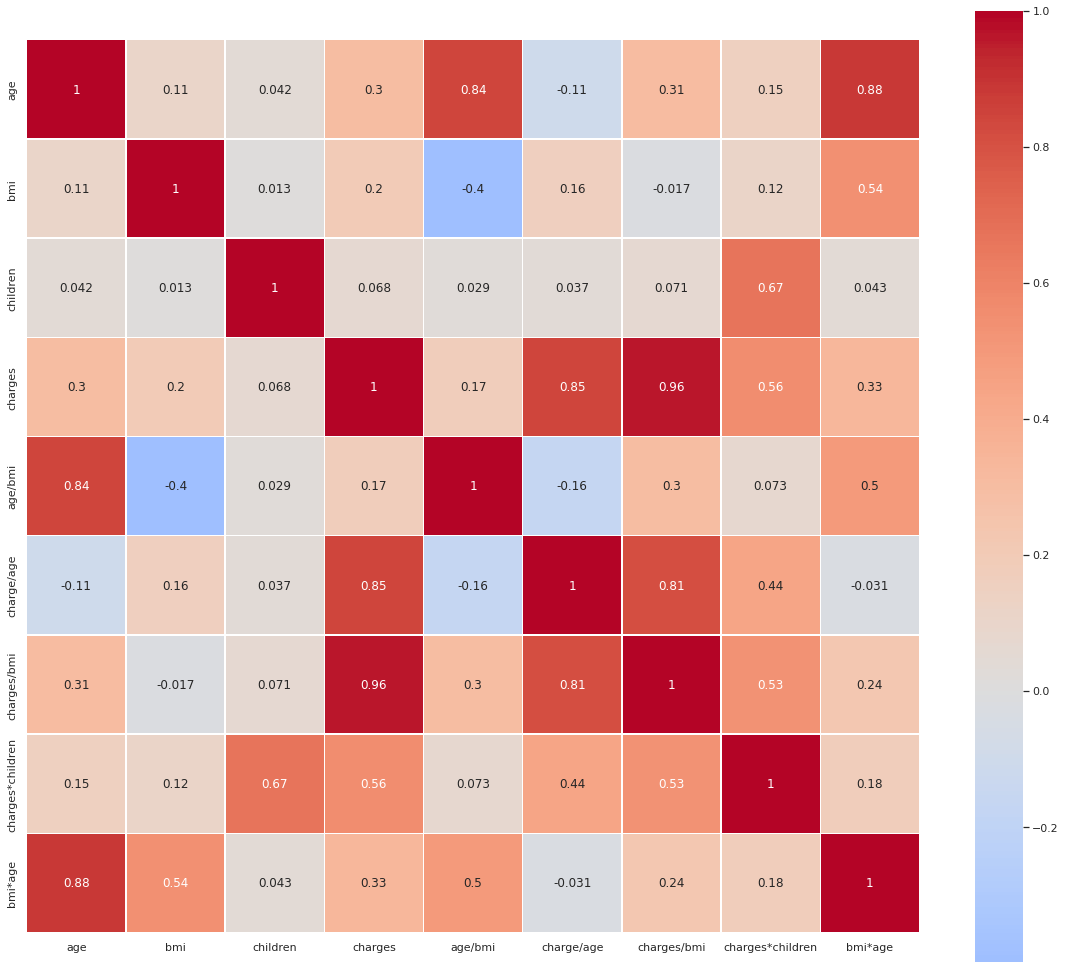

In [50]:
plt.figure(figsize=(20,35))
sns.heatmap(df.corr(),cmap='coolwarm', center=0, square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5})
plt.show()

### Preprocessing

In [51]:
##Converting objects labels into categorical
df[['sex', 'smoker', 'region']] = df[['sex', 'smoker', 'region']].astype('category')
df.dtypes

age                    int64
sex                 category
bmi                  float64
children               int64
smoker              category
region              category
charges              float64
age/bmi              float64
charge/age           float64
charges/bmi          float64
charges*children     float64
bmi*age              float64
dtype: object

In [52]:
##Converting category labels into numerical using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
label.fit(df.sex.drop_duplicates())
df.sex = label.transform(df.sex)
label.fit(df.smoker.drop_duplicates())
df.smoker = label.transform(df.smoker)
label.fit(df.region.drop_duplicates())
df.region = label.transform(df.region)
df.dtypes

age                   int64
sex                   int64
bmi                 float64
children              int64
smoker                int64
region                int64
charges             float64
age/bmi             float64
charge/age          float64
charges/bmi         float64
charges*children    float64
bmi*age             float64
dtype: object

In [53]:
target = df.charges
df = df.drop('charges', axis=1)
df.head()

,age,sex,bmi,children,smoker,region,age/bmi,charge/age,charges/bmi,charges*children,bmi*age
0,19,0,27.900,0,1,3,0.681004,888.680211,605.194409,0.0000,530.100
1,18,1,33.770,1,0,2,0.533017,95.864017,51.097196,1725.5523,607.860
2,28,1,33.000,3,0,2,0.848485,158.909357,134.832182,13348.3860,924.000
3,33,1,22.705,0,0,1,1.453424,666.196079,968.265607,0.0000,749.265
4,32,1,28.880,0,0,1,1.108033,120.839225,133.893878,0.0000,924.160


In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

In [55]:
scaled_df

array([[-1.43876426, -1.0105187 , -0.45332   , ...,  0.4644617 ,
        -0.61632234, -1.30447634],
       [-1.50996545,  0.98959079,  0.5096211 , ..., -1.03907752,
        -0.54780671, -1.1556287 ],
       [-0.79795355,  0.98959079,  0.38330685, ..., -0.81186317,
        -0.08630475, -0.55047577],
       ...,
       [-1.50996545, -1.0105187 ,  1.0148781 , ..., -1.0577147 ,
        -0.61632234, -1.04950585],
       [-1.29636188, -1.0105187 , -0.79781341, ..., -0.96654548,
        -0.61632234, -1.28208028],
       [ 1.55168573, -1.0105187 , -0.26138796, ...,  1.54242514,
        -0.61632234,  1.0751908 ]])

In [56]:
train_df, test_df = train_test_split(scaled_df, test_size=20, random_state=42)
train_label, test_label = train_test_split(target, test_size=20, random_state=42)

### Modeling

**Linear Regression**

In [57]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(train_df, train_label)
pred = lin.predict(test_df)
err = mean_squared_error(test_label, pred)
print(f'MSE is {err}')


MSE is 7933573.725716809


**RandomForrest Regressor**

In [58]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(train_df, train_label)
pred = rf.predict(test_df)
err = mean_squared_error(test_label, pred)
print(f'MSE is {err}')


MSE is 71164.98545880851


**Ridge Regression**

In [59]:
from sklearn.linear_model import Ridge
Ridge = Ridge(alpha=0.5)
Ridge.fit(train_df, train_label)
print(Ridge.intercept_)
print(Ridge.coef_)
print(Ridge.score(test_df, test_label))

13257.445755004772
[ 1114.49214663    72.23633421   252.80718464  -580.96285152
  -170.29364872    53.68609882 -2173.36103684  1973.77505271
  9627.30039069   878.31844078  1647.1530858 ]
0.9677840891912268


In [60]:
from sklearn.linear_model import Lasso
Lasso = Lasso(alpha=0.2, fit_intercept=True, normalize=False, precompute=False, max_iter=1000,
              tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
Lasso.fit(train_df, train_label)
print(Lasso.intercept_)
print(Lasso.coef_)
print(Lasso.score(test_df, test_label))

13257.407836685285
[ 1160.73372872    72.3237527    249.65548352  -577.8674663
  -182.41844804    54.01130275 -2214.5958879   1955.63560361
  9662.92292589   871.52483736  1620.92028216]
0.96782436754185


In [61]:
##Evaluating the performance of the algorithm
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_label, pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_label, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_label, pred)))

Mean Absolute Error: 172.81033161500267
Mean Squared Error: 71164.98545880851
Root Mean Squared Error: 266.76766194351313


In [62]:
!pip install catboost
from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [63]:
cat = CatBoostRegressor()
cat.fit(train_df, train_label)
pred = cat.predict(test_df)
err = mean_squared_error(test_label, pred)
print(f'MSE is {err}')

Learning rate set to 0.042769
0:	learn: 11597.7679445	total: 50.9ms	remaining: 50.8s
1:	learn: 11182.5592579	total: 57.7ms	remaining: 28.8s
2:	learn: 10762.5307386	total: 64.6ms	remaining: 21.5s
3:	learn: 10392.0978720	total: 74.7ms	remaining: 18.6s
4:	learn: 10005.1651501	total: 79.8ms	remaining: 15.9s
5:	learn: 9641.4308252	total: 88.5ms	remaining: 14.7s
6:	learn: 9293.2904916	total: 92.3ms	remaining: 13.1s
7:	learn: 8961.2350342	total: 100ms	remaining: 12.5s
8:	learn: 8628.4449317	total: 106ms	remaining: 11.6s
9:	learn: 8323.7495857	total: 112ms	remaining: 11.1s
10:	learn: 8016.6975505	total: 119ms	remaining: 10.7s
11:	learn: 7727.3384910	total: 127ms	remaining: 10.5s
12:	learn: 7448.2914949	total: 133ms	remaining: 10.1s
13:	learn: 7201.1093095	total: 146ms	remaining: 10.3s
14:	learn: 6954.4166985	total: 156ms	remaining: 10.2s
15:	learn: 6717.4032569	total: 169ms	remaining: 10.4s
16:	learn: 6490.5220392	total: 174ms	remaining: 10.1s
17:	learn: 6276.9011421	total: 219ms	remaining: 11

In [64]:
# The best model is RandomForestRegressor

pred = rf.predict(test_df)
pred

array([ 8999.283568 ,  5274.586614 , 28890.3673843,  9274.188063 ,
       34248.08072  ,  4365.2349235,  2212.9530535, 13987.9220495,
        3756.6580425, 10314.460764 , 18256.3902472,  7242.3305025,
        4008.810762 , 45824.723727 , 48542.7651097, 44994.6826477,
        9729.679212 , 43308.58405  ,  8215.2117115, 21701.3906232])

In [65]:
test_label


764      9095.06825
887      5272.17580
890     29330.98315
1293     9301.89355
259     33750.29180
1312     4536.25900
899      2117.33885
752     14210.53595
1286     3732.62510
707     10264.44210
780     18259.21600
567      7256.72310
76       3947.41310
265     46151.12450
901     48673.55880
893     44202.65360
650      9800.88820
615     42969.85270
538      8233.09750
916     21774.32215
Name: charges, dtype: float64

### Converting Final Result to DataFrame

In [66]:
##Predicting the charges
df = pd.DataFrame({'Actual': test_label, 'Predicted': pred})
df

,Actual,Predicted
764,9095.06825,8999.283568
887,5272.17580,5274.586614
890,29330.98315,28890.367384
1293,9301.89355,9274.188063
259,33750.29180,34248.080720
1312,4536.25900,4365.234924
899,2117.33885,2212.953054
752,14210.53595,13987.922049
1286,3732.62510,3756.658042
707,10264.44210,10314.460764
